<a href="https://colab.research.google.com/github/hectormelo/Machine-Learning-Techniques/blob/main/Taller_3/Taller_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219

Primer semestre - 2024

- **Integrante 1:**
- **Integrante 2:**

Uno de los fenómenos más grandes que se presentan hoy en día son las opiniones de los usuarios sobre diferentes temas a través de Internet. Esta opinión es muy valiosa ya que permite saber en tiempo real y de primera mano los sentimientos que tienen las personas sobre un producto o servicio.

Es por ello, que una cadena hotelera en Andalucía ha decidido extraer la información de las opiniones de sus usuarios que han publicado en internet. Con el fin de poder entender cuáles son las ideas principales de los usuarios acerca de sus servicios, qué aspectos resaltan ellos sobre su servicios y, lo más importante, saber en qué pueden mejorar. Además, con este banco de datos esperan poder entrenar un modelo que les permita automáticamente determinar el sentimiento del usuario basado en las nuevas opiniones que puedan dejar.

Para poder tomar decisiones en este estudio, se debe presentar:

* Un análisis de las palabras más importantes en cada una de las categorías que le den relevancia a la cadena hotelera.

* Un proceso de limpieza y transformación de datos idóneo para el entrenamiento de los algoritmos.

* Una tabla comparativa, mostrando el rendimiento los dos mejores modelos entrenados con Naïve Bayes y KNN.

* A partir de la tabla comparativa, ¿cuál modelo ofrece el mejor rendimiento sobre el conjunto test? ¿Qué interpretación puedes darles a los valores obtenidos sobre las métricas de rendimiento?


**Datos**: Big_AHR.csv

## Diccionario de Datos

# Instalación, importación de librerias y helpers

In [33]:
!pip install ydata-profiling
!pip install contractions
!pip install inflect
!pip install nltk
import nltk
nltk.download('all')


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/willy/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/willy/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/willy/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/willy/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/willy/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to
[nltk_data]    |

True

In [34]:
#Manejo de datos
import pandas as pd
import numpy as np

#Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

#Analisis profundo de datos
from ydata_profiling import ProfileReport

#Entrenamiento del modelo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

# Librería para la creación de nube de etiquetas -Wordcloud.
from wordcloud import WordCloud, STOPWORDS

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

In [35]:
def mostrar_grafico(palabras,stopwords=[]):
    comment_words = ''

    # iterate through the csv file
    for val in palabras:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

    # plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

In [36]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,size=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')



    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Entendimiento del negocio

Se dan a disposición 13330 reviews de los usuarios los cuales están compuestos de la siguiente forma:

* **Review’s title**: Título del review dado por el usuario.
* **5-scale rating**: Calificación del usuario. Escala de 1 a 5.
* **Text**: Review del usuario.
* **City_Region**: Región donde pertenece el hotel.
* **Hotel’s name**: Nombre del hotel evaluado.
* **Binary sentiment label** Clasificación sentimental. Donde 0 es Negativo, 1 es Positivo y 3 es Neutral.

Este es un modelo base, en este caso se realizó la predicción sobre el rating que podría dar un usuario.

# Entendimiento de los datos

## Carga de los datos

In [37]:
url = './Big_AHR.csv'
data = pd.read_csv(url)

Vemos un ejemplo de los datos

In [38]:
data.head()

Unnamed: 0                        title  rating  \
0           0  Excelente y personal amable       5   
1           1                     Céntrico       4   
2           2            Hotel excepcional       5   
3           3                        WOW!!       5   
4           4                    Magnifico       5   

                                         review_text  \
0  Un hotel muy bueno.  El personal fue muy amabl...   
1  Muy buen hotel al nivel de lo esperado, habita...   
2  Magnífico hotel. La verdad es que todo perfect...   
3  Hotel hermoso, buen diseño, original, limpio. ...   
4  Magnífica ubicación en pleno centro de Sevilla...   

                                location                 hotel  label  
0  Seville_Province_of_Seville_Andalucia  H10_Casa_de_la_Plata      1  
1  Seville_Province_of_Seville_Andalucia  H10_Casa_de_la_Plata      1  
2  Seville_Province_of_Seville_Andalucia  H10_Casa_de_la_Plata      1  
3  Seville_Province_of_Seville_Andalucia  H10_Casa_de_la_Plata      1  
4  Seville_Province_of_Seville_Andalucia  H10_Casa_de_la_Plata      1

Hacemos división de nuestros datos en datos de entrenamiento (train) y datos de evaluación (test).

In [39]:
train, test = train_test_split(data, test_size=0.2, random_state=33)

Realizamos un profiling de los datos para ver sus caracteristicas

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

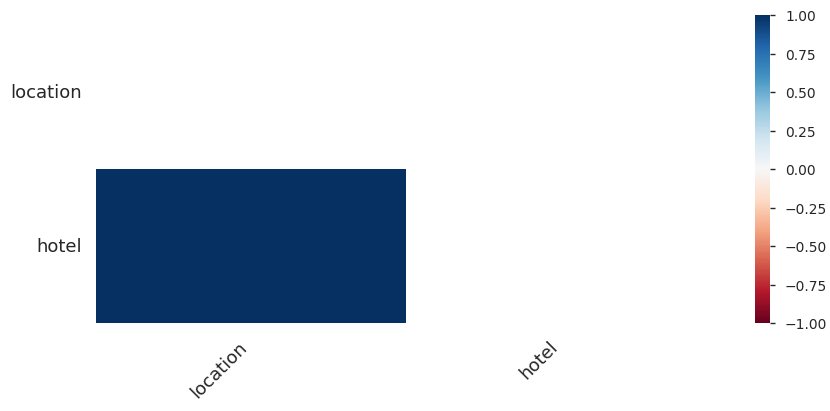

In [40]:
ProfileReport(train)

Con este profiling podemos ver las siguientes cosas sobre los atributos:
- La columna Unnamed 0 tiene una alta corelación con el campo location, esta uniformement distribuida y tiene valores unicos, esto indica que esta columna es un identificador de los datos el cual podemos omitir de los datos.
- Label que es nuestra variable objetivo tiene una alta corelacion con el rating, esto se puede concluir que es porque muchas veces si no nos gusta un restaurante le damos un rating bajo por ejemplo 1 y el label negativo es de 0 que es un numero bajo, lo mismo pasa si ponemos un review positivo, lo mas probable es que pongamos un rating mayor lo cual hace que su label tambien sea mayor tal como 1 o 3, por lo que se pueden concluir que a mayor valor del rating mayor valor del label.
- Location tiene un 9,9% de datos faltantes
- Hotel tiene un 9,9% de datos faltantes

Lo hallazgos mencionados anteriormente no afectan el modelo dado que la variable X que usaremos sera review_text y esta no cuenta con valores faltantes o corelacion directa con el label, asi mismo, la corelacion que tiene el label con rating tampoco sera un problema dado que no usaremos el rating en el modelo.

---------- Words for class: 3 ----------


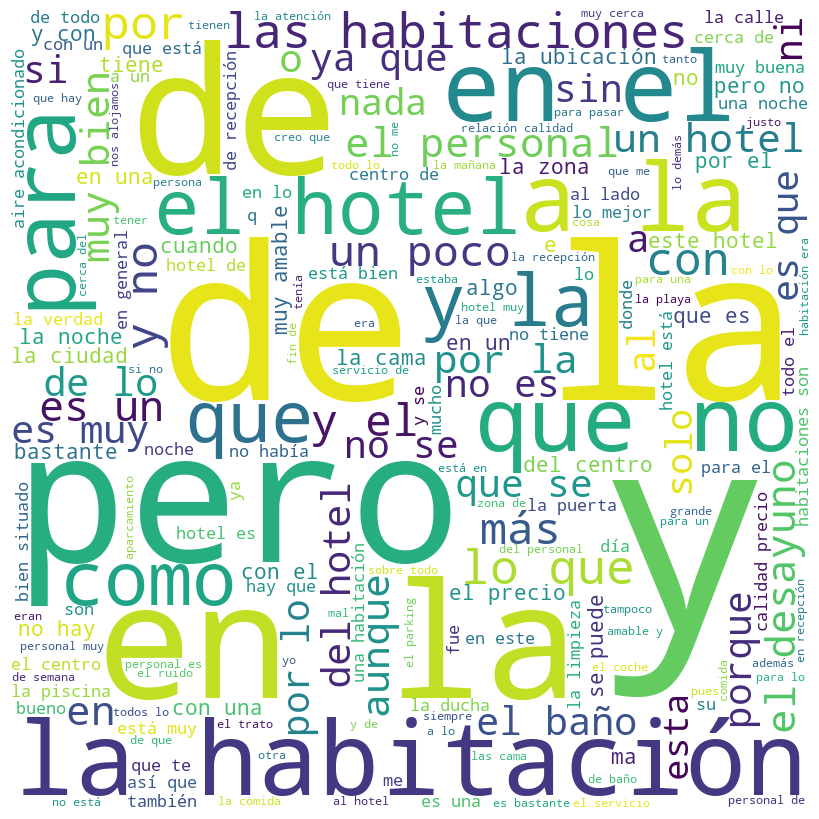

---------- Words for class: 1 ----------


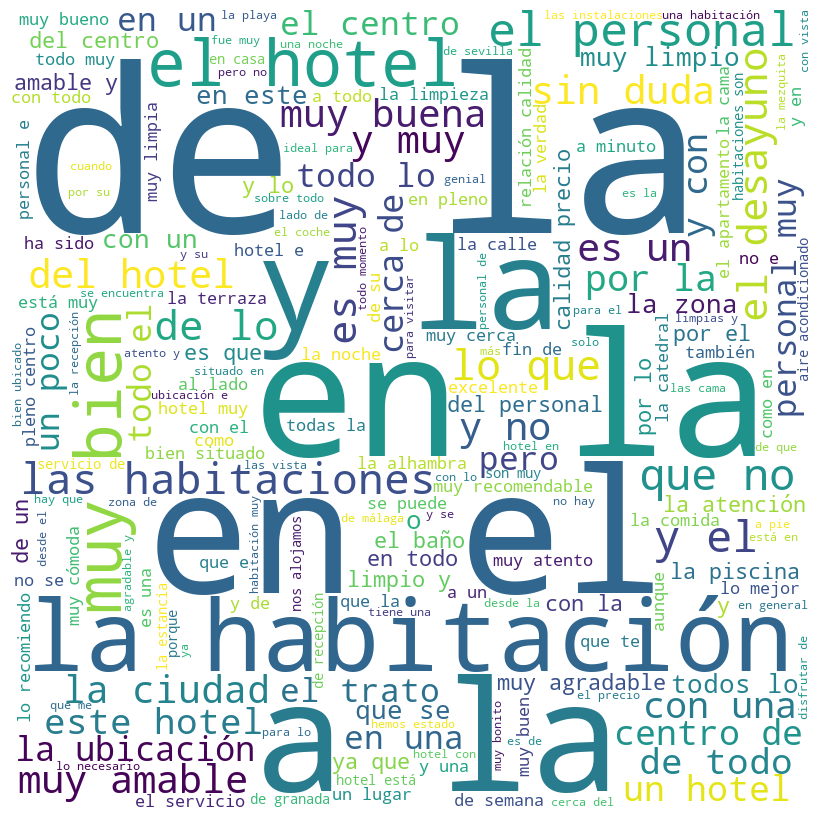

---------- Words for class: 0 ----------


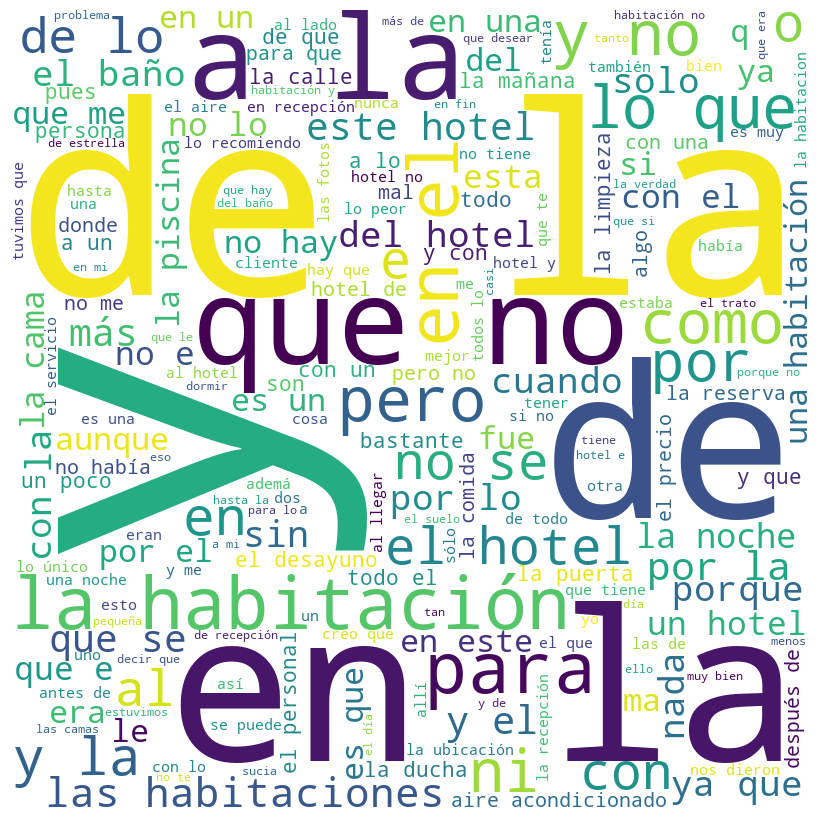

In [41]:
for i in train['label'].unique():
    print(f'---------- Words for class: {i} ----------')
    mostrar_grafico(train.loc[train['label']==i,'review_text'])

Del grafico de palabras podemos observar que hay varios articulos que son los que mayor presencia tienen por lo cual vamos a remover estas palabras haciendo uso de filtrado por Stopwords mas utilizadas en el lenguaje español

---------- Words for class: 3 ----------


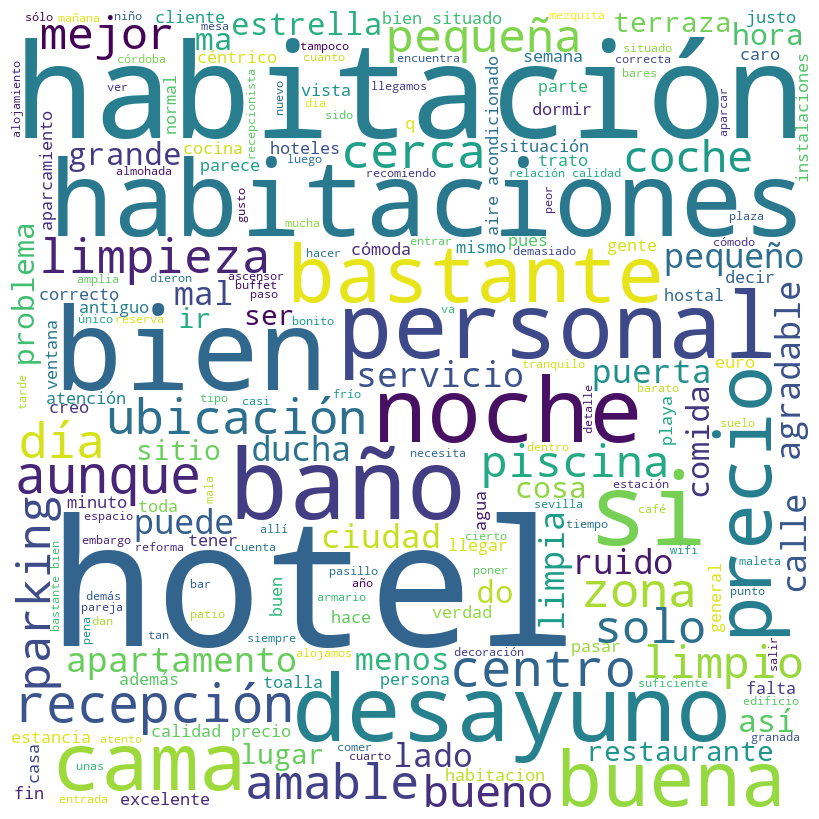

---------- Words for class: 1 ----------


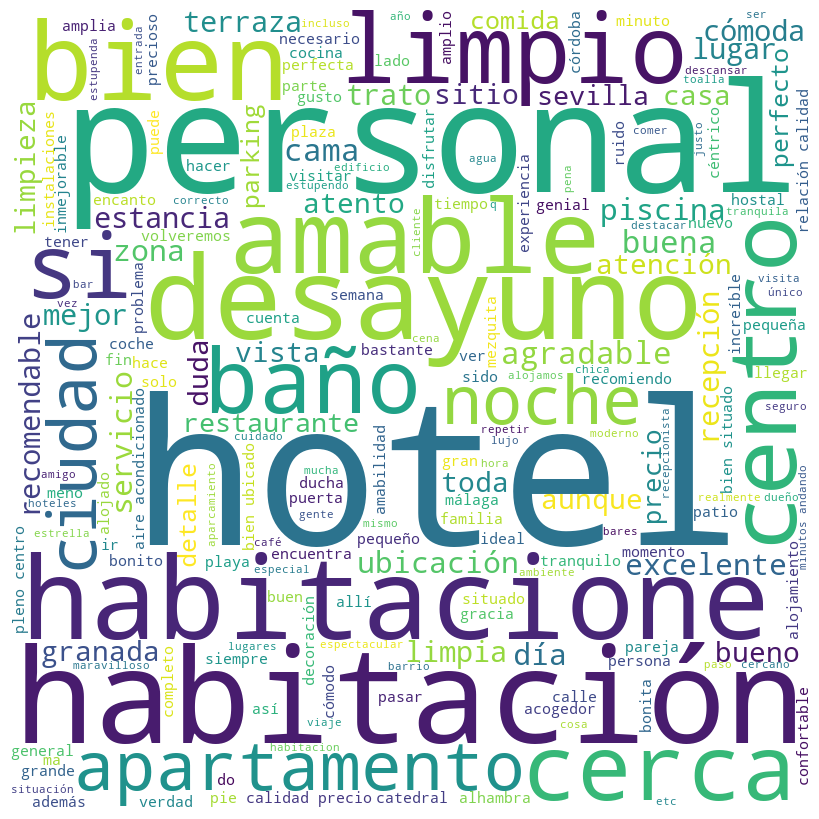

---------- Words for class: 0 ----------


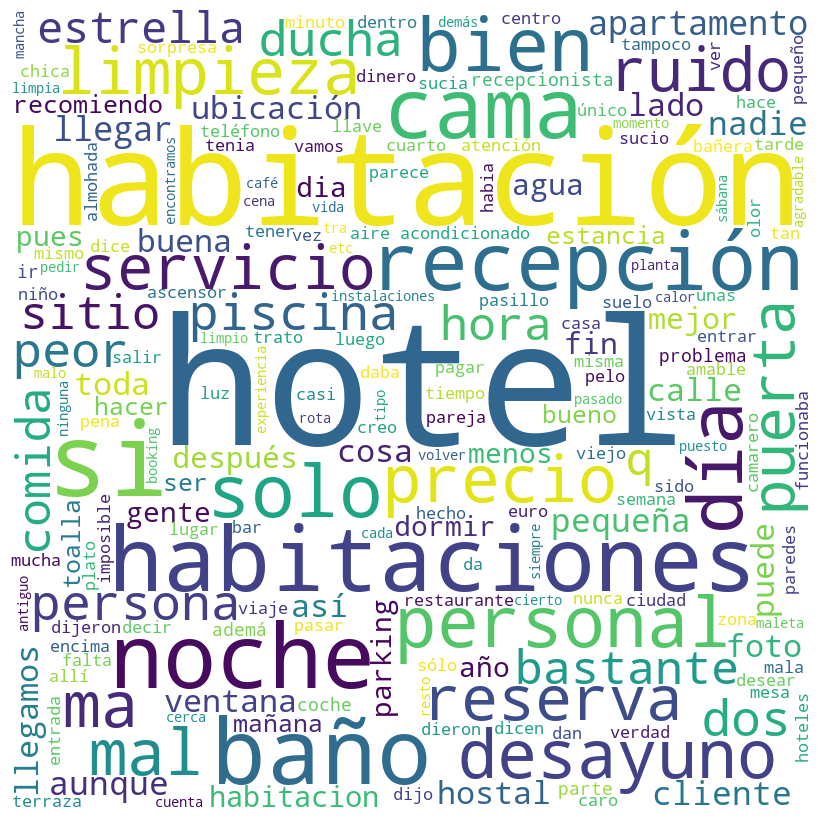

In [42]:
stop_words = stopwords.words('spanish')

for i in train['label'].unique():
    print(f'---------- Words for class: {i} ----------')
    mostrar_grafico(train.loc[train['label']==i,'review_text'], stopwords=stop_words)

Vemos que ahora si se observan mas palabras relacionadas al dominio del problema que estamos resolviendo.

# Preparación de los datos

Dividimos el texto de la categoría a la que pertenece, para poder realizar un análisis por categoría.

In [43]:
X_train, y_train = train['review_text'], train['label']
X_test, y_test = test['review_text'], test['label']

display(X_train)
y_train

15916    Sí, hemos estado en mucho mejor B&B a precios ...
6607     La verdad es que lo mejor es su ubicación y el...
2119     Establecimiento muy sencillo pero que evidenci...
11381    Me daba ciertas garantías un exe pero la limpi...
3803     Un lugar maravilloso. Una casa llena de rincon...
                               ...                        
10435    Estuvimos 4 días en estos apartamentos - estud...
57       Buena localización a 25 minutos de la catedral...
578      Primero para nosotros es muy importante el tra...
5848     Buen lugar, con agradables espacios y una amab...
2439     Sin duda volvería a este hotel que puede ser u...
Name: review_text, Length: 14537, dtype: object

15916    3
6607     3
2119     3
11381    3
3803     1
        ..
10435    1
57       1
578      1
5848     1
2439     1
Name: label, Length: 14537, dtype: int64

Pasamos por las siguientes etapas para poder realizar el pre-procesamiento de los datos:
* Eliminación del Ruido.
* Tokenización.
* Normalización.

## Eliminación de Ruido
Ralizamos eliminación de ruido para dejar el archivo en texto plano, eliminando diferentes fuentes como HTML, Twitter, XML, caracteres especiales y pasar todo a minúscula. Definimos las funciones helper que nos ayudaran en este proceso una vez apliquemos la tokenización.

In [44]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words, stopwords=stopwords.words('spanish')):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def preproccesing(words):
    words = to_lowercase(words)
    #words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

## Tokenización

Con tokenización dividiremos los reviews en palabras para su posterior análisis.

In [45]:
new_X_train = X_train.apply(word_tokenize)
new_X_train = new_X_train.apply(preproccesing)
new_X_train.head()

15916    [si, mejor, b, b, precios, comparables, diseno...
6607     [verdad, mejor, ubicacion, personal, atento, m...
2119     [establecimiento, sencillo, evidencia, interes...
11381    [daba, ciertas, garantias, exe, limpieza, mala...
3803     [lugar, maravilloso, casa, llena, rincones, hi...
Name: review_text, dtype: object

## Normalización

Hacemos una normalización de datos eliminando prefijos y sufijos además realizamos una lemmatización de los verbos para estandarizar verbos conjugados.

In [46]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('spanish')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

Aplicar lematización y stemming

In [47]:
new_X_train = new_X_train.apply(stem_and_lemmatize)
new_X_train.head()

15916    [si, mejor, b, b, preci, compar, disen, medioc...
6607     [verd, mejor, ubic, personal, atent, moment, h...
2119     [establec, sencill, evident, inter, respons, m...
11381    [dab, ciert, garanti, exe, limpiez, mal, 10, 1...
3803     [lug, maravill, cas, llen, rincon, histori, pe...
Name: review_text, dtype: object

# Transformación de los datos

Almacenamos en una columna llamada trans el valor de review_text pero aplicando la transformación que armamos anteriormente para ver la diferencia entre el valor real y el transformado.

In [48]:
train['trans'] = new_X_train.apply(lambda x: ' '.join(map(str, x)))
train

Unnamed: 0                                    title  rating  \
15916       15916        Quizás la mejor opción en la zona       3   
6607         6607                             Esperaba más       3   
2119         2119     Sencillez y buen cuidado para sordos       3   
11381       11381                De los peores hoteles exe       3   
3803         3803                    NocheMagica en Malaga       5   
...           ...                                      ...     ...   
10435       10435   Alojamiento con encanto en el centro.        5   
57             57  Excelente elección para visitar Sevilla       5   
578           578       Muy buen trato y muy buena calidad       5   
5848         5848                            Recomendado!!       5   
2439         2439                       Estancia agradable       4   

                                             review_text  \
15916  Sí, hemos estado en mucho mejor B&B a precios ...   
6607   La verdad es que lo mejor es su ubicación y el...   
2119   Establecimiento muy sencillo pero que evidenci...   
11381  Me daba ciertas garantías un exe pero la limpi...   
3803   Un lugar maravilloso. Una casa llena de rincon...   
...                                                  ...   
10435  Estuvimos 4 días en estos apartamentos - estud...   
57     Buena localización a 25 minutos de la catedral...   
578    Primero para nosotros es muy importante el tra...   
5848   Buen lugar, con agradables espacios y una amab...   
2439   Sin duda volvería a este hotel que puede ser u...   

                                                location  \
15916  Palos_de_la_Frontera_Province_of_Huelva_Andalucia   
6607               Granada_Province_of_Granada_Andalucia   
2119               Seville_Province_of_Seville_Andalucia   
11381              Cordoba_Province_of_Cordoba_Andalucia   
3803             Malaga_Costa_del_Sol_Province_of_Malaga   
...                                                  ...   
10435              Cordoba_Province_of_Cordoba_Andalucia   
57                 Seville_Province_of_Seville_Andalucia   
578                Seville_Province_of_Seville_Andalucia   
5848   Malaga_Costa_del_Sol_Province_of_Malaga_Andalucia   
2439               Seville_Province_of_Seville_Andalucia   

                                                hotel  label  \
15916                               Hotel_Santa_Maria      3   
6607                                           Atenas      3   
2119                            Pension_Dona_Trinidad      3   
11381                           Exe_Ciudad_de_Cordoba      3   
3803   Hotel_Soho_Boutique_Castillo_de_Santa_Catalina      1   
...                                               ...    ...   
10435                     Apartamentos_Cordoba_Atrium      1   
57                                      Melia_Sevilla      1   
578                                       Hotel_Kivir      1   
5848                                  El_Riad_Andaluz      1   
2439                           Eurostars_Guadalquivir      1   

                                                   trans  
15916  si mejor b b preci compar disen mediocr mejor ...  
6607   verd mejor ubic personal atent moment habit te...  
2119   establec sencill evident inter respons manten ...  
11381  dab ciert garanti exe limpiez mal 10 1430h aun...  
3803   lug maravill cas llen rincon histori personal ...  
...                                                  ...  
10435  4 dias apartament estudi situacion inmejor est...  
57     buen localiz 25 minut catedral pie permiti mov...  
578    primer import trat recepcion cafeteri sid magn...  
5848   buen lug agrad espaci amabl atencion duen habi...  
2439   dud volveri hotel pued ser mejor 4 estrell cre...  

[14537 rows x 8 columns]

Ademas de esta transformación podemos usar las siguientes para realizar el procesamiento por parte del algoritmo que escojamos para el modelo.

- Transformación binaria: Haciendo uso de CountVectorizer podemos asigna un valor binario único a cada caracter esto con el proposito de convertir el texto a una representación que permita realizar operaciones lógicas bit a bit facilitando la comparación de cadenas.
- Transformación no binaria: Haciendo uso de CountVecotirzer podemos contar las apariciones de cada caracter en el documento terminando con una matriz de solo numeros.
- Term-frecuency times inverse Document-frecuency: es una técnica utilizada para ponderar la importancia de palabras en documentos en relación con un conjunto de documentos o corpus.

### Transformación binaria de ejemplo

In [49]:
dummy = CountVectorizer(binary=True)
X_dummy = dummy.fit_transform(train['trans'])
print(X_dummy.shape)
X_dummy[0]

(14537, 16994)


<1x16994 sparse matrix of type '<class 'numpy.int64'>'
	with 45 stored elements in Compressed Sparse Row format>

### Transformación no binaria de ejemplo

In [50]:
count = CountVectorizer()
X_count = count.fit_transform(train['trans'])
print(X_count.shape)

(14537, 16994)


### Term-frecuency times inverse Document-frecuency de ejemplo

In [51]:
tf_idf = TfidfVectorizer()
X_tf_idf = tf_idf.fit_transform(train['trans'])
print(X_tf_idf.shape)

(14537, 16994)


# Modelado

### Creación pipeline

Para cada algoritmo crearemos un pipeline que se encargara de ejecutar los pasos realizados anteriormente de forma automatica.

- Preprocesaiento (Eliminación de ruido, tokenización y normalización)
- Transformación de los datos (Transformación no binaria)
- Ejecutar algoritmo

La siguiente clase recopila los preprocesamientos realizados anteriormente para poder incluirlos en los pipeline.

In [52]:
class TextPreprocessing(BaseEstimator,TransformerMixin):
    def __init__(self,stopwords=stopwords.words('spanish')):
        self.stopwords = stopwords

    def remove_non_ascii(self, words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words

    def to_lowercase(self, words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words

    def remove_punctuation(self, words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words

    def replace_numbers(self, words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words

    def remove_stopwords(self, words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in self.stopwords:
                new_words.append(word)
        return new_words

    def stem_words(self, words):
        """Stem words in list of tokenized words"""
        stemmer = SnowballStemmer('spanish')
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems

    def lemmatize_verbs(self, words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas

    def stem_and_lemmatize(self, words):
        words = self.stem_words(words)
        words = self.lemmatize_verbs(words)
        return words

    def preproccesing(self, words):
        words = self.to_lowercase(words)
        words = self.replace_numbers(words)
        words = self.remove_punctuation(words)
        words = self.remove_non_ascii(words)
        words = self.remove_stopwords(words)
        return words

    def fit(self,X,y=None):
        return self

    def transform(self,X,y=None):
        new_X_train = pd.Series(X)
        new_X_train = new_X_train.apply(contractions.fix)
        new_X_train = new_X_train.apply(word_tokenize)
        new_X_train = new_X_train.apply(lambda x: self.preproccesing(x))
        new_X_train = new_X_train.apply(lambda x: self.stem_and_lemmatize(x))
        new_X_train = new_X_train.apply(lambda x: ' '.join(map(str, x)))
        return new_X_train

## Naïve Bayes

Naive Bayes es un tipo de algoritmo que trabaja bajo el supuesto de que las características de los datos son independientes entre sí para predecir la categoría de nuevos datos, para hacer la predicción se basa en el teorema de bayes.

### Crear pipeline y modelo

Bayes requiere una dense matriz por lo cual se requiere agregar un paso extra en el pipeline que haga la conversión de la matriz

In [53]:
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [54]:
%%time
estimators = [
        ('preproccess',TextPreprocessing()),
        ('transform',CountVectorizer(lowercase=False)),
        ('to_dense', DenseTransformer()), 
        ('classifier', GaussianNB())
    ]
pipe_Bayes = Pipeline(estimators)

pipe_Bayes.fit(X_train, y_train)

CPU times: user 13.7 s, sys: 1.85 s, total: 15.5 s
Wall time: 16.6 s


Pipeline(steps=[('preproccess', TextPreprocessing()),
                ('transform', CountVectorizer(lowercase=False)),
                ('to_dense', <__main__.DenseTransformer object at 0x2a299ece0>),
                ('classifier', GaussianNB())])

### Predicción con datos de entrenamiento

In [55]:
y_pred_train_Bayes = pipe_Bayes.predict(X_test)
y_pred_train_Bayes

array([0, 1, 3, ..., 1, 1, 3])

### Resultados

Confusion matrix, without normalization


<Axes: title={'center': 'Matriz de Confusión'}, xlabel='Predicted label', ylabel='True label'>

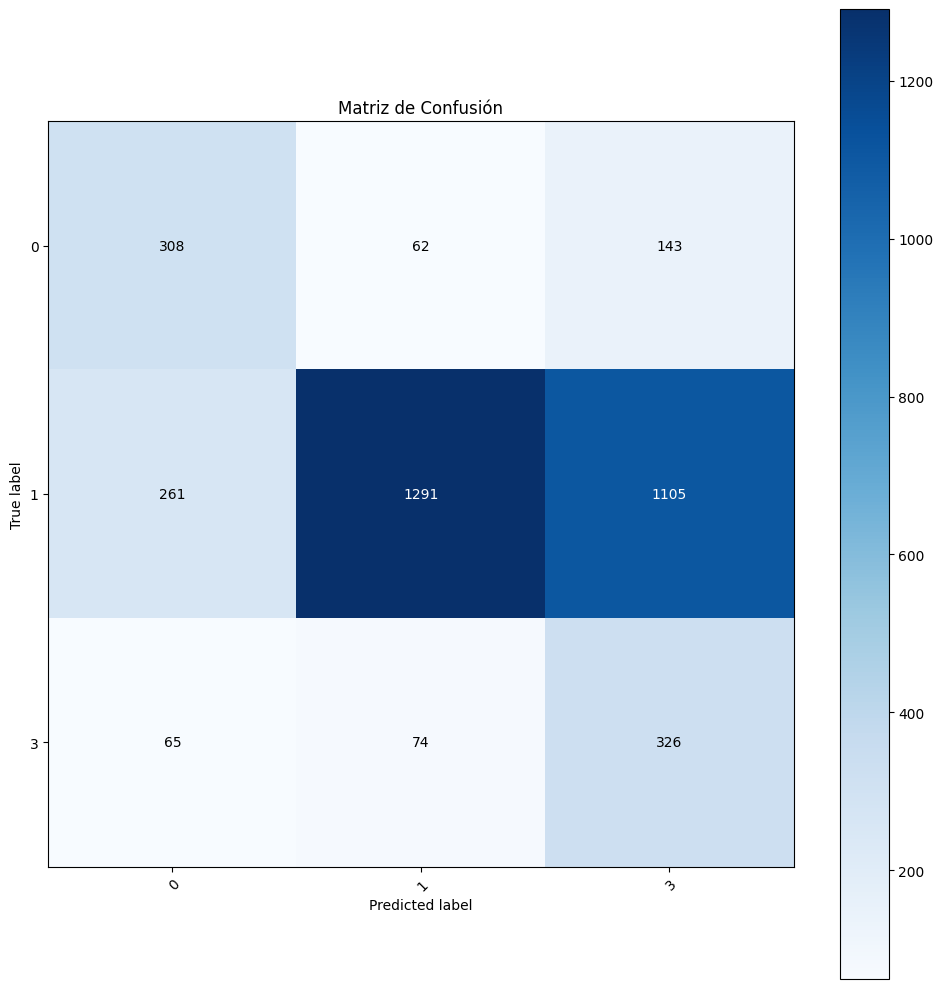

In [56]:
%matplotlib inline

classes = pipe_Bayes['classifier'].classes_

plot_confusion_matrix(y_true=y_test, y_pred=y_pred_train_Bayes, classes=classes,
                      title='Matriz de Confusión')

In [57]:
report_Bayes = classification_report(y_test, y_pred_train_Bayes)
print("Train Report for Naive Bayes\n", report_Bayes)

Train Report for Naive Bayes
               precision    recall  f1-score   support

           0       0.49      0.60      0.54       513
           1       0.90      0.49      0.63      2657
           3       0.21      0.70      0.32       465

    accuracy                           0.53      3635
   macro avg       0.53      0.60      0.50      3635
weighted avg       0.76      0.53      0.58      3635



Vemos que el modelo tiene una precisión del 76% y un recall bajo del 53%, si vemos la matriz de confusión hubo varios fallos en la clase 1 en la cual se clasifico 1105 datos en clase 3 pero en realidad era 1, por lo cual concluimos que el modelo no diferencia correctamente entre clase 1 y 3.

## KNN


KNN, o k-Nearest Neighbors, es un tipo de algoritmo que predice la categoría de nuevos datos basándose en la similitud con los datos más cercanos en su conjunto de entrenamiento. Para hacer la predicción, selecciona los "k" datos más cercanos o similares y, según la categoría predominante entre esos vecinos, clasifica el nuevo dato.

### Crear pipeline y modelo

Inicialmente se ejecuta KNN usando 3 vecinos como K.

In [58]:
%%time
estimators = [
        ('preproccess',TextPreprocessing()),
        ('transform',CountVectorizer(lowercase=False)),
        ('to_dense', DenseTransformer()), 
        ('classifier', KNeighborsClassifier())
    ]
pipe_KNN = Pipeline(estimators)

pipe_KNN.fit(X_train, y_train)

CPU times: user 12.8 s, sys: 229 ms, total: 13 s
Wall time: 12.8 s


Pipeline(steps=[('preproccess', TextPreprocessing()),
                ('transform', CountVectorizer(lowercase=False)),
                ('to_dense', <__main__.DenseTransformer object at 0x2a9c32ce0>),
                ('classifier', KNeighborsClassifier())])

### Predicción con datos de entrenamiento

In [59]:
y_pred_train_KNN = pipe_KNN.predict(X_test)
y_pred_train_KNN

array([1, 1, 1, ..., 1, 1, 1])

### Resultados

Confusion matrix, without normalization


<Axes: title={'center': 'Matriz de Confusión'}, xlabel='Predicted label', ylabel='True label'>

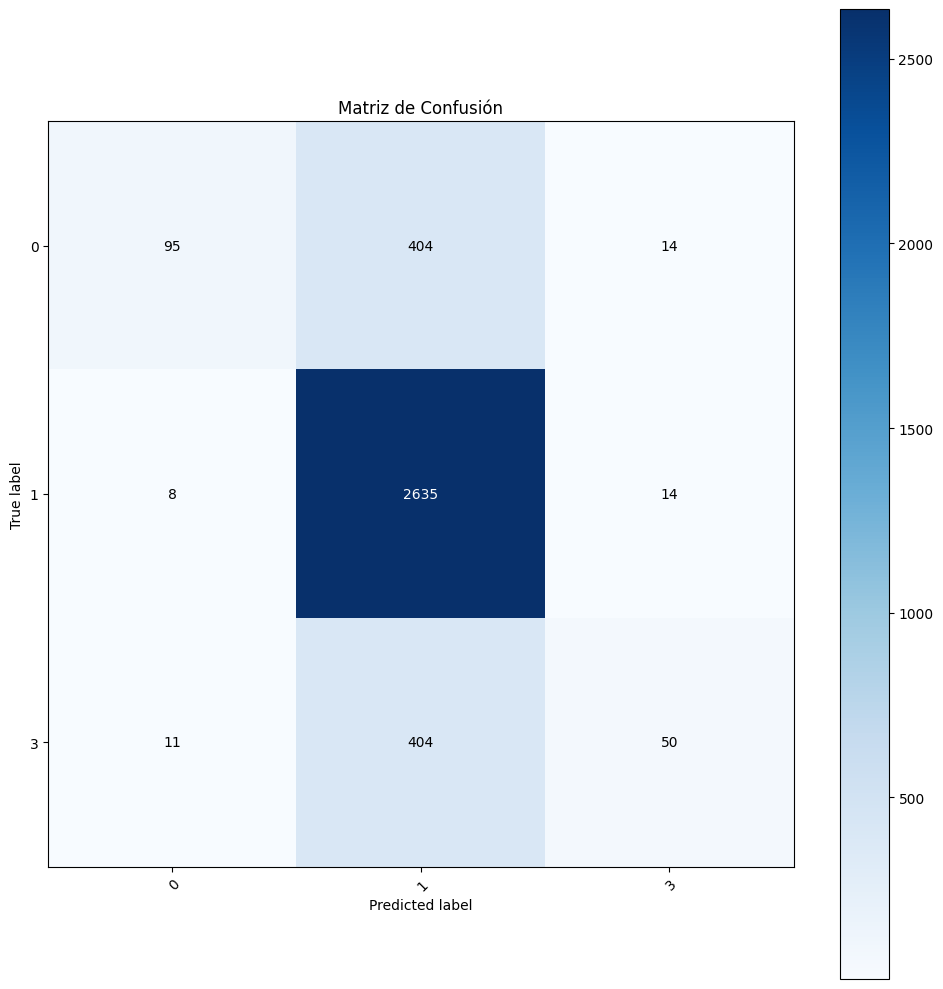

In [60]:
%matplotlib inline

classes = pipe_KNN['classifier'].classes_

plot_confusion_matrix(y_true=y_test, y_pred=y_pred_train_KNN, classes=classes,
                      title='Matriz de Confusión')

In [61]:
report_KNN = classification_report(y_test, y_pred_train_KNN)
print("Train Report for KNN\n", report_KNN)

Train Report for KNN
               precision    recall  f1-score   support

           0       0.83      0.19      0.30       513
           1       0.77      0.99      0.86      2657
           3       0.64      0.11      0.18       465

    accuracy                           0.76      3635
   macro avg       0.75      0.43      0.45      3635
weighted avg       0.76      0.76      0.70      3635



Vemos que el modelo tiene una precisión del 76% y un recall bajo del 76%, si vemos la matriz de confusión hubo varios fallos en la clase 0 y 3 en los cuals se clasifico 404 datos en clase 1, por lo cual concluimos que el modelo tiene un sesgo hacia la clase 1.

# Optimización de parametros

## Naive Bayes

Vamos a hacer una optimización de parametros variando el tipo de transformación utilizada para ejecutar Naive Bayes

In [62]:
parameters = {
    'transform':[CountVectorizer(binary=True,lowercase=False),CountVectorizer(lowercase=False),TfidfVectorizer(lowercase=False)],
    'classifier': [BernoulliNB(), MultinomialNB(), GaussianNB() ],
}

## 11 minutes aprox
grid_search_Bayes = GridSearchCV(pipe_Bayes, parameters, scoring='precision_macro', cv=5, error_score=0.0, n_jobs=-1)

In [63]:
%%time
grid_search_Bayes.fit(X_train,y_train)

CPU times: user 11min 15s, sys: 1min 34s, total: 12min 49s
Wall time: 11min 17s


GridSearchCV(cv=5, error_score=0.0,
             estimator=Pipeline(steps=[('preproccess', TextPreprocessing()),
                                       ('transform',
                                        CountVectorizer(lowercase=False)),
                                       ('to_dense',
                                        <__main__.DenseTransformer object at 0x2a299ece0>),
                                       ('classifier', GaussianNB())]),
             param_grid={'classifier': [BernoulliNB(), MultinomialNB(),
                                        GaussianNB()],
                         'transform': [CountVectorizer(binary=True,
                                                       lowercase=False),
                                       CountVectorizer(lowercase=False),
                                       TfidfVectorizer(lowercase=False)]},
             scoring='precision_macro')

A continuación podemos ver el mejor estimador resultado del GridSearch

In [64]:
grid_search_Bayes.best_estimator_

Pipeline(steps=[('preproccess', TextPreprocessing()),
                ('transform', CountVectorizer(binary=True, lowercase=False)),
                ('to_dense', <__main__.DenseTransformer object at 0x2a1e66f50>),
                ('classifier', MultinomialNB())])

Predicción utilizando datos test

In [65]:
y_pred_train_GBayes = grid_search_Bayes.best_estimator_.predict(X_test)

In [66]:
report_GBayes = classification_report(y_test, y_pred_train_GBayes)

print("Train Report\n", report_GBayes)

Train Report
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       513
           1       0.92      0.95      0.93      2657
           3       0.56      0.48      0.51       465

    accuracy                           0.87      3635
   macro avg       0.77      0.74      0.76      3635
weighted avg       0.86      0.87      0.86      3635



Podemos ver que con estos ajustes aumentamos de una precision del 76% al 86% y de un recall de 53% a 87%

## KNN

Vamos a hacer una optimización de parametros variando los siguientes valores

- Numero de vecinos a considerar para la predicción
- Forma en que se calcula el peso distancia o uniforme
- Metrica resultado del peso, inicialmente se hizo pruebas con euclidean y manhattan sin embargo tomaba mucho tiempo su calculo.

In [67]:
parameters = {
    'classifier__n_neighbors': [3, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean']

}
grid_search_KNN = GridSearchCV(pipe_KNN, parameters, scoring='precision_macro', cv=5, error_score=0.0, verbose=3, n_jobs=-1)

In [68]:
%%time
grid_search_KNN.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 13.9 s, sys: 1.34 s, total: 15.3 s
Wall time: 6min 42s


GridSearchCV(cv=5, error_score=0.0,
             estimator=Pipeline(steps=[('preproccess', TextPreprocessing()),
                                       ('transform',
                                        CountVectorizer(lowercase=False)),
                                       ('to_dense',
                                        <__main__.DenseTransformer object at 0x2a9c32ce0>),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__metric': ['euclidean'],
                         'classifier__n_neighbors': [3, 11],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='precision_macro', verbose=3)

A continuación podemos ver el mejor estimador resultado del GridSearch

In [69]:
grid_search_KNN.best_estimator_

Pipeline(steps=[('preproccess', TextPreprocessing()),
                ('transform', CountVectorizer(lowercase=False)),
                ('to_dense', <__main__.DenseTransformer object at 0x2a9c32230>),
                ('classifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=11,
                                      weights='distance'))])

Predicción utilizando datos test

In [70]:
y_pred_train_GKNN = grid_search_KNN.best_estimator_.predict(X_test)

In [71]:
report_GKNN = classification_report(y_test, y_pred_train_GKNN)

print("Train Report\n", report_GKNN)

Train Report
               precision    recall  f1-score   support

           0       0.99      0.37      0.54       513
           1       0.82      1.00      0.90      2657
           3       0.92      0.37      0.53       465

    accuracy                           0.83      3635
   macro avg       0.91      0.58      0.66      3635
weighted avg       0.85      0.83      0.80      3635

[CV 4/5] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=distance;, score=0.834 total time= 3.2min
[CV 5/5] END classifier__metric=euclidean, classifier__n_neighbors=11, classifier__weights=uniform;, score=0.704 total time= 3.2min
[CV 2/5] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__weights=distance;, score=0.825 total time= 3.2min
[CV 4/5] END classifier__metric=euclidean, classifier__n_neighbors=11, classifier__weights=distance;, score=0.910 total time= 3.2min
[CV 3/5] END classifier__metric=euclidean, classifier__n_neighbors=3, classi

Podemos ver que con estos ajustes aumentamos de una precision del 76% al 85% y de un recall de 76% a 83%

# Comparación modelos

In [77]:
data = {
    'Modelo': ['Bayes base (Naive)', 'KNN', 'Bayes optimizado (Multinomial)', 'KNN optimizado'],
    'Accuracy': ['76%', '76%', '86%', '85%'],
    'Recall': ['53%', '76%', '87%', '83%'],
    'F1 Score': ['58%', '70%', '86%', '80%']
}

df = pd.DataFrame(data)
df.set_index('Modelo', inplace=True)
df

Accuracy Recall F1 Score
Modelo                                                 
Bayes base (Naive)                  76%    53%      58%
KNN                                 76%    76%      70%
Bayes optimizado (Multinomial)      86%    87%      86%
KNN optimizado                      85%    83%      80%

Podemos ver que los modelos optimizados tienen mayor score que los iniciales, esto dado que se hace una busqueda y ajuste de hiperparametros haciendo uso de cross-validation. Por otro lado aunque vemos que el accuracy de KNN optimizado es bastante cercano al de Bayes Multinomial, a nivel de recall se tiene una mayor diferencia de 3% lo cual se puede ver a la hora de calcular el F1 score donde se ve un gap de 6%. El anterior resultado es dado que Bayes multinomial tiene mejor eficiencia con datos de alta dimensionalidad teniendo en cuenta que para ambos se hizo la transformación de la matriz de datos de una matriz dispersa a una densa. Este performance en datos de alta dimensionalidad ayudo a que Bayes multinomial pudiera ejecutar mas iteraciones de busqueda de hiperparametros para asi encontrar mejores scores, se podria llegar a un mejor resultado con KNN si se continuara la busqueda de hiperparametros sin embargo esto es computacionalmente mas costoso que Bayes multinomial que trabaja directamente con probabilidades condicionales y tardaria mas tiempo.